Notebook to merge ATL, CPR and AC products

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch


In [2]:
# _test = '_TEST10'
_test = ''

In [3]:
a = xr.open_dataset(f"AC__TC__2B_1s{_test}.nc")
a

sh: 1: getfattr: not found


<xarray.Dataset> Size: 15MB
Dimensions:    (time: 167119)
Coordinates:
  * time       (time) datetime64[ns] 1MB 2025-06-12T06:53:45 ... 2025-09-10T1...
Data variables:
    latitude   (time) float64 1MB ...
    longitude  (time) float64 1MB ...
    stc_2500   (time) float64 1MB ...
    stc_5000   (time) float64 1MB ...
    stc_7500   (time) float64 1MB ...
    stc_10000  (time) float64 1MB ...
    stc_12500  (time) float64 1MB ...
    stc_15000  (time) float64 1MB ...
    stc_17500  (time) float64 1MB ...
    stc_20000  (time) float64 1MB ...

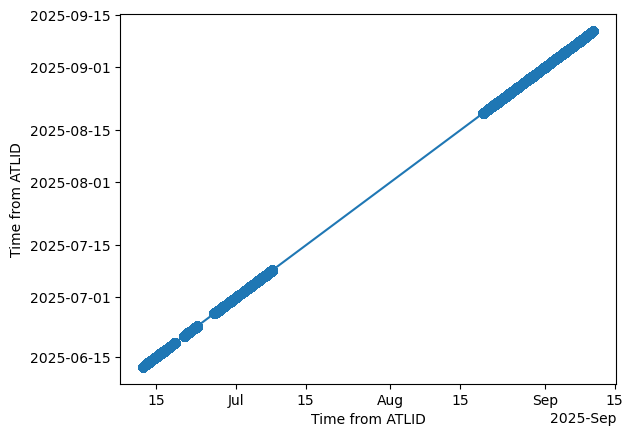

In [4]:
a.time.plot(marker='o')

Tricky coverage: AC_TC is available only half-june / half-july and september


In [5]:
b = xr.open_dataset(f"CPR_CLD_2A_1s{_test}.nc")
b

sh: 1: getfattr: not found


<xarray.Dataset> Size: 19MB
Dimensions:            (time: 470101)
Coordinates:
  * time               (time) datetime64[ns] 4MB 2025-03-11T03:57:14 ... 2025...
Data variables:
    latitude           (time) float64 4MB ...
    longitude          (time) float64 4MB ...
    land_flag          (time) float64 4MB ...
    ice_water_path     (time) float32 2MB ...
    liquid_water_path  (time) float32 2MB ...

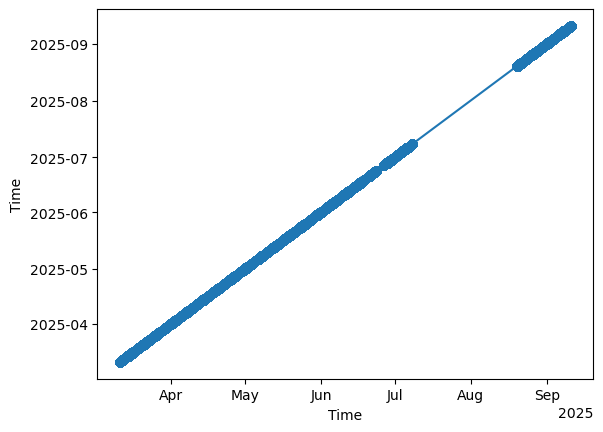

In [6]:
b.time.plot(marker='o')

Coverage: from April to July, then September

In [7]:
challenge = a.merge(b[['land_flag', 'ice_water_path', 'liquid_water_path']], join='outer', compat='override')

In [8]:
c = xr.open_dataset('../shared-buckets/e87a5ac1-705f-410b-8253-2b53c6d8eaab/aot_resampled.nc')
c

<xarray.Dataset> Size: 608kB
Dimensions:                          (time: 50652)
Coordinates:
  * time                             (time) datetime64[ns] 405kB 2025-03-12T0...
Data variables:
    aerosol_optical_thickness_355nm  (time) float32 203kB ...

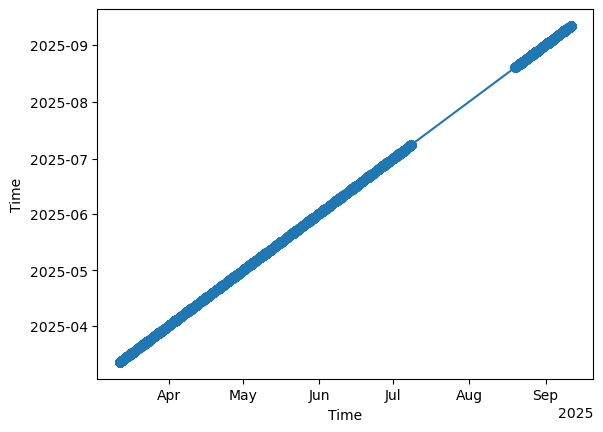

In [9]:
c.time.plot(marker='o')

In [10]:
challenge = challenge.merge(c, join='outer', compat='override')
challenge

<xarray.Dataset> Size: 56MB
Dimensions:                          (time: 520966)
Coordinates:
  * time                             (time) datetime64[ns] 4MB 2025-03-11T03:...
Data variables: (12/14)
    latitude                         (time) float64 4MB nan nan nan ... nan nan
    longitude                        (time) float64 4MB nan nan nan ... nan nan
    stc_2500                         (time) float64 4MB nan nan nan ... nan nan
    stc_5000                         (time) float64 4MB nan nan nan ... nan nan
    stc_7500                         (time) float64 4MB nan nan nan ... nan nan
    stc_10000                        (time) float64 4MB nan nan nan ... nan nan
    ...                               ...
    stc_17500                        (time) float64 4MB nan nan nan ... nan nan
    stc_20000                        (time) float64 4MB nan nan nan ... nan nan
    land_flag                        (time) float64 4MB 0.0 0.0 0.0 ... nan nan
    ice_water_path                   (time) float32 2MB nan nan nan ... nan nan
    liquid_water_path                (time) float32 2MB nan nan nan ... nan nan
    aerosol_optical_thickness_355nm  (time) float32 2MB nan nan ... 0.1781

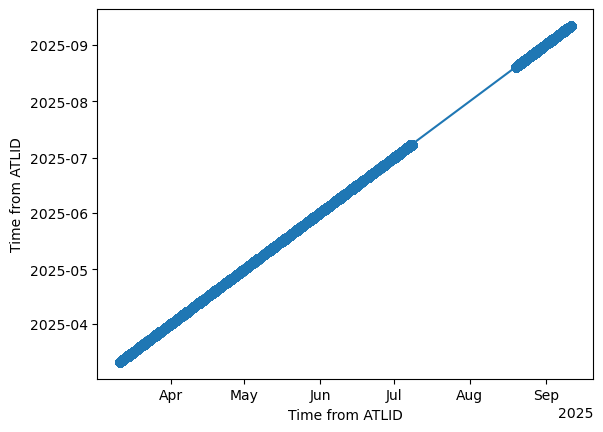

In [11]:
challenge.time.plot(marker='o')

## Let's put nans to zero when sensors are working and sky is clear

In [12]:
numerical_variables = [
    'latitude',
    'longitude',
    'land_flag',
    'ice_water_path', 
    'liquid_water_path', 
    'aerosol_optical_thickness_355nm'
]

In [13]:
challenge[numerical_variables[2:]] = challenge[numerical_variables[2:]].fillna(0).clip(min=0, max=1e2)


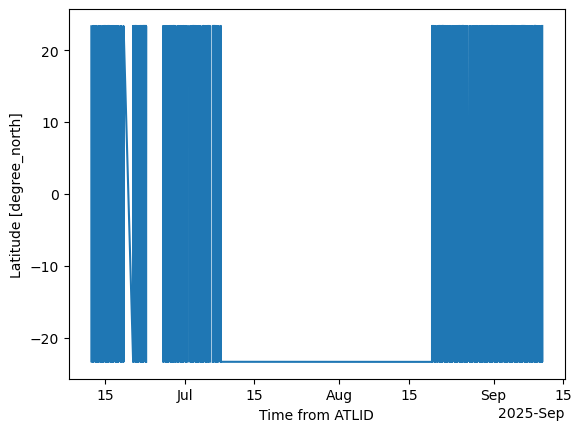

In [14]:
challenge['latitude'].plot()

Now the resampling can be done with how='any'

## Now resample again to 1min
to coarser times to get both aerosols and clouds in the same pixel

Numerical variables with mean:

In [15]:
challenge_1min_numerical = challenge[numerical_variables].resample(time='1min').mean().dropna(dim='time', how='any')
challenge_1min_numerical

<xarray.Dataset> Size: 133kB
Dimensions:                          (time: 3012)
Coordinates:
  * time                             (time) datetime64[ns] 24kB 2025-06-12T06...
Data variables:
    latitude                         (time) float64 24kB 22.89 20.47 ... 23.25
    longitude                        (time) float64 24kB 108.7 108.2 ... 115.5
    land_flag                        (time) float64 24kB 0.2667 0.2143 ... 0.0
    ice_water_path                   (time) float32 12kB 0.1019 0.2666 ... 0.0
    liquid_water_path                (time) float32 12kB 0.1735 0.2327 ... 0.0
    aerosol_optical_thickness_355nm  (time) float32 12kB 0.0 1.139 ... 0.0

In [16]:
10554/12/5/30 # how many months?

5.863333333333333

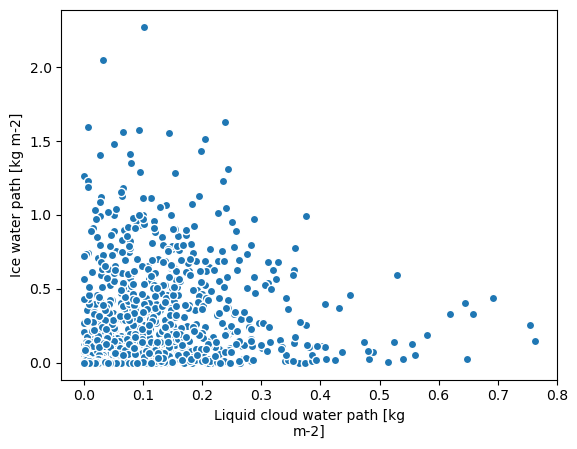

In [17]:
challenge_1min_numerical.plot.scatter(x='liquid_water_path', y='ice_water_path')

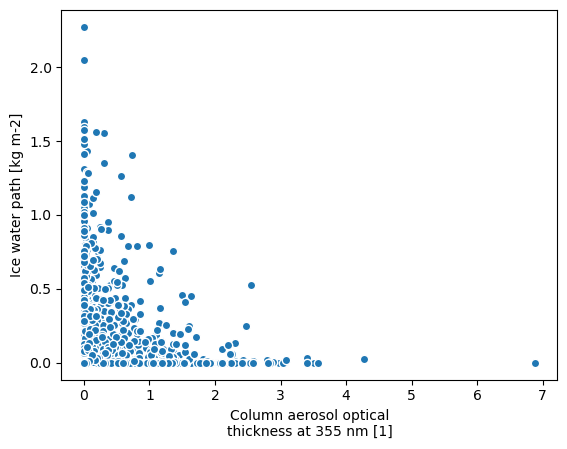

In [18]:
challenge_1min_numerical.plot.scatter(x='aerosol_optical_thickness_355nm', y='ice_water_path')
# plt.xscale('log')

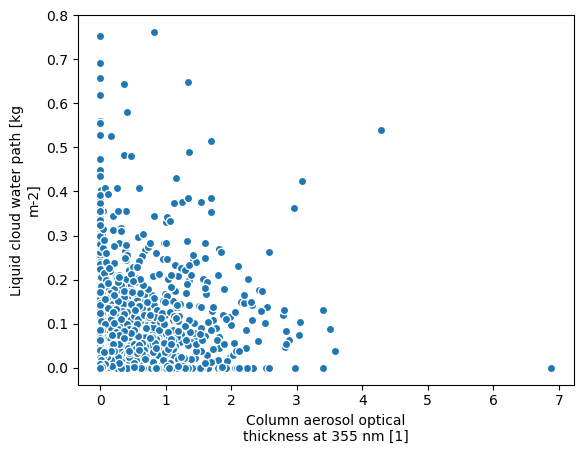

In [19]:
challenge_1min_numerical.plot.scatter(x='aerosol_optical_thickness_355nm', y='liquid_water_path')


## Save the k-means ready dataset

In [20]:
challenge_1min_numerical.to_netcdf('challenge_1min_numerical.nc')

sh: 1: getfattr: not found


## Resample also the label variables

In [21]:
def mode_func(arr, axis):
    # scipy returns both mode and count, we only want the mode
    return stats.mode(arr, axis=axis, keepdims=False).mode   # , nan_policy="omit"

challenge_1min_labels = (
    challenge
    .drop_vars(numerical_variables)
    .resample(time="1min")
    .reduce(mode_func)
    .dropna(dim="time", how="any")
)

challenge_1min_labels

<xarray.Dataset> Size: 217kB
Dimensions:    (time: 3012)
Coordinates:
  * time       (time) datetime64[ns] 24kB 2025-06-12T06:53:00 ... 2025-09-10T...
Data variables:
    stc_2500   (time) float64 24kB -1.0 11.0 11.0 11.0 7.0 ... 7.0 28.0 1.0 -1.0
    stc_5000   (time) float64 24kB -1.0 11.0 5.0 11.0 7.0 ... 1.0 1.0 1.0 -1.0
    stc_7500   (time) float64 24kB -1.0 13.0 7.0 13.0 7.0 ... 1.0 1.0 1.0 -1.0
    stc_10000  (time) float64 24kB -1.0 7.0 13.0 13.0 13.0 ... 1.0 1.0 1.0 -1.0
    stc_12500  (time) float64 24kB -1.0 1.0 13.0 14.0 21.0 ... 1.0 1.0 1.0 -1.0
    stc_15000  (time) float64 24kB -1.0 1.0 21.0 21.0 ... 21.0 21.0 1.0 -1.0
    stc_17500  (time) float64 24kB -1.0 1.0 21.0 21.0 1.0 ... 1.0 1.0 1.0 -1.0
    stc_20000  (time) float64 24kB -1.0 1.0 1.0 1.0 1.0 ... 33.0 1.0 1.0 -1.0

In [22]:
challenge_1min_complete = challenge_1min_numerical.merge(challenge_1min_labels, join='outer', compat='override')
challenge_1min_complete

<xarray.Dataset> Size: 325kB
Dimensions:                          (time: 3012)
Coordinates:
  * time                             (time) datetime64[ns] 24kB 2025-06-12T06...
Data variables: (12/14)
    latitude                         (time) float64 24kB 22.89 20.47 ... 23.25
    longitude                        (time) float64 24kB 108.7 108.2 ... 115.5
    land_flag                        (time) float64 24kB 0.2667 0.2143 ... 0.0
    ice_water_path                   (time) float32 12kB 0.1019 0.2666 ... 0.0
    liquid_water_path                (time) float32 12kB 0.1735 0.2327 ... 0.0
    aerosol_optical_thickness_355nm  (time) float32 12kB 0.0 1.139 ... 0.0
    ...                               ...
    stc_7500                         (time) float64 24kB -1.0 13.0 ... 1.0 -1.0
    stc_10000                        (time) float64 24kB -1.0 7.0 ... 1.0 -1.0
    stc_12500                        (time) float64 24kB -1.0 1.0 ... 1.0 -1.0
    stc_15000                        (time) float64 24kB -1.0 1.0 ... 1.0 -1.0
    stc_17500                        (time) float64 24kB -1.0 1.0 ... 1.0 -1.0
    stc_20000                        (time) float64 24kB -1.0 1.0 ... 1.0 -1.0

## Save the k-means ready dataset with TC labels and layers

In [23]:
challenge_1min_complete.to_netcdf('challenge_1min_complete.nc')

sh: 1: getfattr: not found
